In [1]:
import cv2
import numpy as np
from glob import glob
import os
import tifffile as tiff # for reading .TIFF files
import glymur as glm # for reading .JP2 files (needs openjpeg)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_folders = glob('data' + os.sep + '*')

## Synthetic Aperture Radar (SAR) Image processing

Here we will begin by analyzing images captured by the SAR (Synthetic Aperture Radar) satellites. The SAR data presented herein contains images taken in 2 polarization modes - 

1. VV - Vertical Transmit, Vertical Receive : Same polarization like this can help distinguish same surfaces having different states (like capillary waves in water bodies)

2. VH - Vertical Transmit, Horizontal Receive : Cross-polarisation like this is useful when volume (multiple) scattering occurs. It can allow the separation of soil and vegetation and of forest and non-forest.

Here, we will try to utilize their natures to find water body masks from the radar images.

In [4]:
# ---------------------SAR (Synthetic Aperture Radar) PROCESSING--------------------- #

sentinel_1_SAR_folders = [d for d in data_folders if 'S1' in d]

s1a_201808_folder = [f for f in sentinel_1_SAR_folders if '201808' in f][0]
s1a_201809_folder = [f for f in sentinel_1_SAR_folders if '201809' in f][0]

Analyzing SAR images from 08/2018-

In [10]:
# Performs exploratory data analysis by performing image addition,
# subtraction, & multiplication. Only useful for observing patterns
# manually and making algorithms.
def sar_image_analyze_explore(sar_folder_path,
                              create_split_viz=False,
                              reorient=True,
                              bypass_ops=False):
    img_list_suffix = 'measurement' + os.sep + '*.tiff'

    img_paths = glob(sar_folder_path + os.sep + img_list_suffix)

    if create_split_viz: #creates chunked viewable 8-bit histogram normalized images for human viewing;
        for img_path in img_paths:
            preprocess_images(img_path)

    vh_path = [p for p in img_paths if '-vh-' in p][0]
    vv_path = [p for p in img_paths if '-vv-' in p][0]

    im_vh = tiff.imread(vh_path)
    im_vv = tiff.imread(vv_path)

    out_dir = sar_folder_path.split(os.sep)[-1] + '_analysis'
    force_makedir(out_dir)

    if reorient: #original images are north-south flipped, this corrects it
        im_vh = np.flipud(im_vh)
        im_vv = np.flipud(im_vv)
        tiff.imsave(open(vh_path.replace('.tiff', '_reoriented.tiff'), 'wb'), im_vh)
        tiff.imsave(open(vv_path.replace('.tiff', '_reoriented.tiff'), 'wb'), im_vv)

    if not bypass_ops:

        vh_vv_diff = cv2.subtract(im_vh, im_vv)
        vv_vh_diff = cv2.subtract(im_vv, im_vh)

        vhvv_diff_path = out_dir + os.sep + 'vh_vv_diff.tiff'
        vvvh_diff_path = out_dir + os.sep + 'vv_vh_diff.tiff'

        tiff.imsave(open(vhvv_diff_path, 'wb'), vh_vv_diff)
        tiff.imsave(open(vvvh_diff_path, 'wb'), vv_vh_diff)

        vh_vv_add = cv2.add(im_vh, im_vv)
        vh_vv_mul = cv2.multiply(im_vh, im_vv)

        vhvv_add_path = out_dir + os.sep + 'vh_vv_add.tiff'
        vhvv_mul_path = out_dir + os.sep + 'vh_vv_mul.tiff'

        tiff.imsave(open(vhvv_add_path, 'wb'), vh_vv_add)
        tiff.imsave(open(vhvv_mul_path, 'wb'), vh_vv_mul)

    return im_vh, im_vv, out_dir

def force_makedir(dir):
    if not os.path.isdir(dir):
        os.makedirs(dir)

In [9]:
sar_folder_path = s1a_201808_folder

# Simply reading the tiff files
im_vh, im_vv, out_dir = sar_image_analyze_explore(sar_folder_path,
                                                  create_split_viz=False,
                                                  reorient=True,
                                                  bypass_ops=True)

Water bodies are very reflective surfaces. They tend to completely reflect all the radar energy away from them at an angle equal to the incidence anglemaking them appear dark in both VH & VV images. The same applies to smooth surfaces like runways etc.

Here, we will be highlighting water bodies and airport runway stretches which is otherwise, less observed in the original radar images. 

We shall do this by multiplying the VH & VV images and thresholding the resulting image at the mean - standard_deviation of all of its pixels.

After performing some cleaning an dpost-processing on this image, the water bodies become apparent.

In [10]:
def find_waterish_surface_mask(im_vh, im_vv):
    vh_vv_mul = cv2.multiply(im_vh, im_vv)
    m = vh_vv_mul.max()
    vh_vv_mul[vh_vv_mul > (vh_vv_mul.mean() - vh_vv_mul.std())] = 0
    vh_vv_mul[vh_vv_mul > 0] = m
    return vh_vv_mul

In [11]:
waterish_mask_raw = find_waterish_surface_mask(im_vh, im_vv)

#Saving the 16-bit image
tiff.imsave(open(out_dir + os.sep + 'waterish_mask_raw.tiff', 'wb'), waterish_mask_raw)

In [13]:
watermask_viz = waterish_mask_raw.copy()
watermask_viz[watermask_viz > 0] = 255
watermask_viz = watermask_viz.astype(np.uint8)

Original shape = (16685, 26545)
Scaled down shape = (1668, 2654)


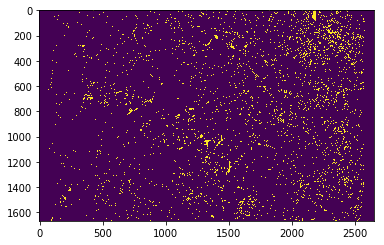

In [29]:
print('Original shape =', watermask_viz.shape)
h, w = watermask_viz.shape
viz = cv2.resize(watermask_viz, (int(w * .1), int(h * .1)), interpolation=cv2.INTER_NEAREST)
print('Scaled down shape =', viz.shape)
plt.imshow(viz)
plt.show()

This image doesn't visually reveal too much as there is significant downsampling happening over here (more than 90% of the pixels are lost). Therefore, screenshots of the results will be shown for better visibility.

Now we shall clean this image of noisy spots with the following method -

In [30]:
def sar_water_mask_postprocess(waterish_mask_raw, out_dir):
    # Performing Dilation followed by Erosion
    waterish_mask_raw_morphclosed = cv2.morphologyEx(waterish_mask_raw, cv2.MORPH_CLOSE,
                                                    cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_morphclosed.tiff', 'wb'), waterish_mask_raw_morphclosed)
    
    # Performing Erosion followed by Dilation
    waterish_mask_raw_morphclosed_morphopened = cv2.morphologyEx(waterish_mask_raw_morphclosed, cv2.MORPH_OPEN,
                                                                cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
                                                                iterations=1)
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_morphclosed_morphopened.tiff', 'wb'),
                waterish_mask_raw_morphclosed_morphopened)
    
    # Filtering out small speckles (blobs whose area is lesser than mean blob area
    # are removed)
    _, polys, _ = cv2.findContours(waterish_mask_raw_morphclosed_morphopened.astype(np.uint8),
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    poly_areas = np.array([cv2.contourArea(poly) for poly in polys])
    polys_mask = poly_areas > poly_areas.mean()
    chosen_polys = np.array(polys)[polys_mask]
    waterish_mask_raw_morphclosed_morphopened_polycleaned = np.zeros_like(waterish_mask_raw_morphclosed_morphopened)
    cv2.drawContours(waterish_mask_raw_morphclosed_morphopened_polycleaned, chosen_polys, -1,
                     65535, -1)
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_morphclosed_morphopened_polycleaned.tiff', 'wb'),
                waterish_mask_raw_morphclosed_morphopened_polycleaned)

    return waterish_mask_raw_morphclosed_morphopened_polycleaned

In [31]:
waterish_mask_postprocessed = sar_water_mask_postprocess(waterish_mask_raw, out_dir)

In [3]:
def u16_to_u8(im):
    a = (im / 65535) * 255
    a = a.astype(np.uint8)
    return a

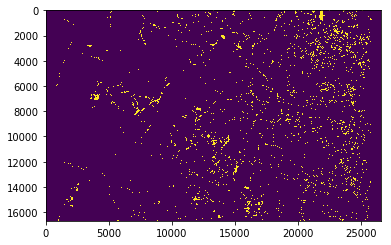

In [34]:
viz = u16_to_u8(waterish_mask_postprocessed)
plt.imshow(viz)
plt.show()

A side-by-side baked visualization of the results is shown below-

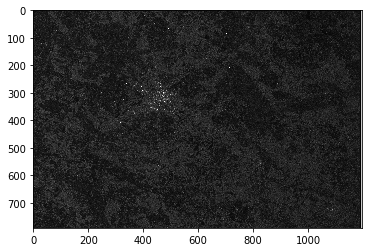

In [36]:
im = cv2.imread('s1a_comparison_org.png')
plt.imshow(im)
plt.show()

This is the original image

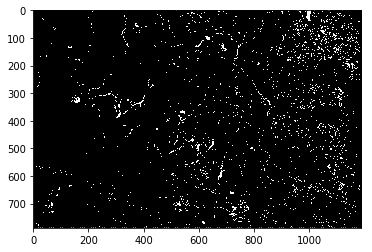

In [37]:
im = cv2.imread('s1a_comparison_watermask.png')
plt.imshow(im)
plt.show()

This is the watermask extracted. Although there isn't too much of a quality improvement, it is more visible. For better comparison, please see the files 's1a_comparison_org.png' and 's1a_comparison_watermask.png' representing the original and the watermask extracted images respectively.

Now we shall process the other radar image from 09/2018-

In [38]:
# Putting all the above methods in to one function

def sar_image_process(sar_folder_path, create_split_viz=False, reorient=True, bypass_exploration=False):
    im_vh, im_vv, out_dir = sar_image_analyze_explore(sar_folder_path,
                                                      create_split_viz=create_split_viz,
                                                      reorient=reorient,
                                                      bypass_ops=bypass_exploration)
    waterish_mask_raw = find_waterish_surface_mask(im_vh, im_vv)
    tiff.imsave(open(out_dir + os.sep + 'waterish_mask_raw.tiff', 'wb'), waterish_mask_raw)

    waterish_mask_postprocessed = sar_water_mask_postprocess(waterish_mask_raw, out_dir)

    return waterish_mask_postprocessed

In [39]:
water_mask_201809 = sar_image_process(s1a_201809_folder, create_split_viz=False,
                                      reorient=True, bypass_exploration=True)

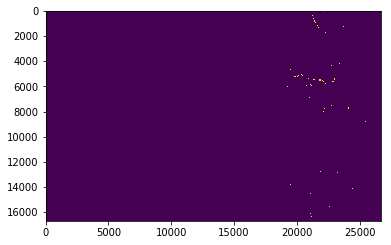

In [40]:
viz = u16_to_u8(water_mask_201809)
plt.imshow(viz)
plt.show()

As this again doesn't reveal much visually, the baked results are presented below -

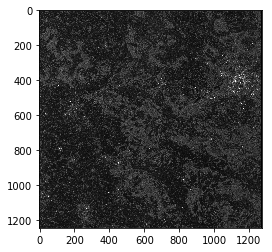

In [41]:
im = cv2.imread('s1b_comparison_org.png')
plt.imshow(im)
plt.show()

This is the original image

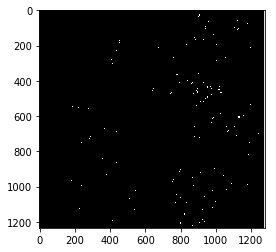

In [42]:
im = cv2.imread('s1b_comparison_watermask.png')
plt.imshow(im)
plt.show()

This image is quite sparse in terms of water bodies so its even less evident on the notebook. However, the corresponding file visualizations can be viewed in 's1b_comparison_org.png' and 's1b_comparison_watermask.png' for original and watermask images respectively.

## Multi Spectral Imager (MSI) image processing

Images obtained from MSI satellites extend over a wide EM spectrum bandwidth surpassing that what the human eye can see (Including infra-red and ultra-violet). The full spectrum with its details can be found at https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument

In the images provided to us, the images range over 12 spectral bandwidths. Having multi-spectral images is very useful in addition to having true color images obtained from traditional cameras operating more or less in the same visual spectrum as humans as they can help segment and detect important features  in satellite images. This is possible as different map features (like clouds, soil, vegetation) produce different responses to EM radiations of different wavelengths.

We shall leverage this property here to minimize the obsucurity caused by the clouds in the true color images.

In [7]:
sentinel_2_MSI_folders = [d for d in data_folders if 'S2' in d]

The following image visualizes the coverage of the various MSI images from 09/2016. This has been obtained from the tile numbers (T33UUT & T33UUU) as cited in the data folders.

The mapping betweem tileID and their enclosing lat-long can be found at https://sentinel.esa.int/documents/247904/1955685/S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00.kml

The lat-longs for each tile are as follows -

#### 33UUT lat longs-

52.3140232376153,12.0657982282501  
51.3280532477758,12.1292108515397  
51.3560798433897,13.7045784646816  
52.3430543844249,13.6759245503229 


#### 33UUU lat longs- (a tile north of 33UUT)

53.2119778260595,12.0047609250912  
52.2262108698791,12.071595116355  
52.2551507482845,13.6785440650184  
53.241963547145,13.648341514502

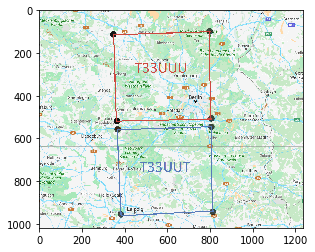

In [44]:
im = cv2.imread('s2a_msi_coverage_201609.png')
plt.imshow(im)
plt.show()

In [5]:
# south
s2a_201609_l1c_t33uut_folder = [f for f in sentinel_2_MSI_folders if '201609' in f and 'T33UUT' in f][0]
print('We shall begin with processing folder', s2a_201609_l1c_t33uut_folder)

We shall begin with processing folder data\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE


In [8]:
folder_path = s2a_201609_l1c_t33uut_folder
root_dir_path_prefix = folder_path + os.sep + 'GRANULE'
root_dir_path = glob(root_dir_path_prefix + os.sep + '*')[0]

img_dir_path = root_dir_path + os.sep + 'IMG_DATA'
gml_dir_path = root_dir_path + os.sep + 'QI_DATA'

out_dir = folder_path.split(os.sep)[-1]
force_makedir(out_dir)

spectral_img_paths = glob(img_dir_path + os.sep + '*_B*.jp2')
spectral_img_paths = np.array([p for p in spectral_img_paths if '_B8A' not in p])
spectral_indices = np.array([int(p.split('_')[-1][1:].replace('.jp2', '')) for p in spectral_img_paths])

# Choosing respective B, G & R channels to use for recovering cloud-masked regions
# These numbers represent spectral indices of different spectral maps
# captured by the MSI satellite.
cloud_removal_bgr_extraction_channel_indices = [5, 10, 11]

In [10]:
spectral_indices = spectral_indices - 1
spectral_indices_argsorted = np.argsort(spectral_indices)
spectral_img_paths_sorted = spectral_img_paths[spectral_indices_argsorted]
print(spectral_img_paths_sorted)

[ 'data\\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE\\GRANULE\\L1C_T33UUT_A006640_20160929T102344\\IMG_DATA\\T33UUT_20160929T102022_B01.jp2'
 'data\\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE\\GRANULE\\L1C_T33UUT_A006640_20160929T102344\\IMG_DATA\\T33UUT_20160929T102022_B02.jp2'
 'data\\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE\\GRANULE\\L1C_T33UUT_A006640_20160929T102344\\IMG_DATA\\T33UUT_20160929T102022_B03.jp2'
 'data\\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE\\GRANULE\\L1C_T33UUT_A006640_20160929T102344\\IMG_DATA\\T33UUT_20160929T102022_B04.jp2'
 'data\\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE\\GRANULE\\L1C_T33UUT_A006640_20160929T102344\\IMG_DATA\\T33UUT_20160929T102022_B05.jp2'
 'data\\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUT_20160929T102344.SAFE\\GRANULE\\L1C_T33UUT_A006640_20160929T102344\\IMG_DATA\\T33UUT_20160929T102022_B06.jp2'
 'data\\S2A_MSIL1C_20160929

The file paths are sorted above according to their spectral indices ranging from 1 to 12.

In [11]:
spectral_imgs = np.array(list(map(glm.Jp2k, spectral_img_paths_sorted)))

# These are the height and width of the true color image provided.
tcl_height, tcl_width = spectral_imgs[1].shape

print('True color height =', tcl_height)
print('True color width =', tcl_width)

True color height = 10980
True color width = 10980


Now we shall create cloud masks from the .GML polygon files provided in the data folder.

In [12]:
cloudmask_filepath = gml_dir_path + os.sep + 'MSK_CLOUDS_B00.gml'
with open(cloudmask_filepath, 'rb') as f:
    cloudmasks_raw = f.readlines()

We will use custom code to parse the GML files in XML format to ease package dependency

In [13]:
cloud_types=['OPAQUE', 'CIRRUS'] # the types of clouds we want to clean
mask_tags_raw = np.array([t for t in cloudmasks_raw if 'gml:posList' in str(t)])
indices = []
for cloud_type in cloud_types:
    mask_type_tags_raw = np.array([str(t) for t in cloudmasks_raw if 'maskType' in str(t)])
    local_indices = [i for i in range(len(mask_type_tags_raw))
                     if cloud_type in mask_type_tags_raw[i]]
    indices += local_indices

In [14]:
mask_tags_raw = mask_tags_raw[indices]
mask_tags_str = [str(mask_tag.strip())[2:-1]
                 [len('<gml:posList srsDimension="2">')
                  :-len('</gml:posList srsDimension="2">')]
                 for mask_tag in mask_tags_raw]
cloud_polypoints_raw = [np.array(list(map(int, mask_tag_str.split(' ')))).reshape([-1, 2])[:-1]
                        for mask_tag_str in mask_tags_str]

In [15]:
bl_xy = [300004, 5690215]
tr_xy = [409805, 5800015]
local_height = tr_xy[1] - bl_xy[1]
local_width = tr_xy[0] - bl_xy[0]
offsetting_fn = lambda cld_pp_raw: np.abs([0, tr_xy[1]] - (cld_pp_raw - [bl_xy[0], 0])) / \
                                   [local_width, local_height]

In [16]:
cloudmasks_normalized_xy = list(map(offsetting_fn, cloud_polypoints_raw))

Let's now pack this in to a neat function -

In [17]:
def extract_cloudmasks(cloudmasks_raw, cloud_types=['OPAQUE', 'CIRRUS'],
                       bl_xy = [300004, 5690215], tr_xy = [409805, 5800015]):
    mask_tags_raw = np.array([t for t in cloudmasks_raw if 'gml:posList' in str(t)])

    indices = []
    for cloud_type in cloud_types:
        mask_type_tags_raw = np.array([str(t) for t in cloudmasks_raw if 'maskType' in str(t)])
        local_indices = [i for i in range(len(mask_type_tags_raw))
                         if cloud_type in mask_type_tags_raw[i]]
        indices += local_indices

    mask_tags_raw = mask_tags_raw[indices]

    mask_tags_str = [str(mask_tag.strip())[2:-1]
                     [len('<gml:posList srsDimension="2">')
                      :-len('</gml:posList srsDimension="2">')]
                     for mask_tag in mask_tags_raw]
    cloud_polypoints_raw = [np.array(list(map(int, mask_tag_str.split(' ')))).reshape([-1, 2])[:-1]
                            for mask_tag_str in mask_tags_str]
#     bl_xy = [300004, 5690215]
#     tr_xy = [409805, 5800015]
    local_height = tr_xy[1] - bl_xy[1]
    local_width = tr_xy[0] - bl_xy[0]
    offsetting_fn = lambda cld_pp_raw: np.abs([0, tr_xy[1]] - (cld_pp_raw - [bl_xy[0], 0])) / \
                                       [local_width, local_height]
    cloud_polypoints_local = list(map(offsetting_fn, cloud_polypoints_raw))
    return cloud_polypoints_local

Now we shall create the mask image -

In [18]:
scale_fn = lambda cmsk_norm: (cmsk_norm * [tcl_width, tcl_height]).astype(np.int32)
cloudmasks_scaled = list(map(scale_fn, cloudmasks_normalized_xy))

cloudmask_reconstructed = np.zeros([tcl_height, tcl_width], dtype=np.uint8)
for i in range(len(cloudmasks_scaled)):
    cv2.drawContours(cloudmask_reconstructed, cloudmasks_scaled, i, 255, -1)

In [19]:
cloudmask_img_path = out_dir + os.sep + 'gml_cloudmasks_reconstructed.png'
cv2.imwrite(cloudmask_img_path, cloudmask_reconstructed)

True

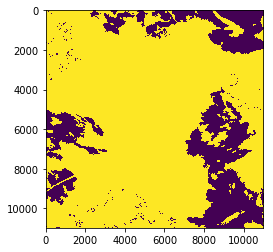

In [20]:
plt.imshow(cloudmask_reconstructed)
plt.show()

This cloud-mask cover (brighter regions are the clouds) includes both cirrus and opaque clouds. We shall now pack all of this in to a function -

In [21]:
def get_cloudmask_image(cloudmasks_raw, cloud_types=['OPAQUE', 'CIRRUS']):
    cloudmasks_normalized_xy = extract_cloudmasks(cloudmasks_raw, cloud_types=cloud_types)

    scale_fn = lambda cmsk_norm: (cmsk_norm * [tcl_width, tcl_height]).astype(np.int32)
    cloudmasks_scaled = list(map(scale_fn, cloudmasks_normalized_xy))

    cloudmask_reconstructed = np.zeros([tcl_height, tcl_width], dtype=np.uint8)
    for i in range(len(cloudmasks_scaled)):
        cv2.drawContours(cloudmask_reconstructed, cloudmasks_scaled, i, 255, -1)
    
    return cloudmask_reconstructed

The other masks corresponding to opaque & cirrus clouds are as follows -

Opaque cloud mask-


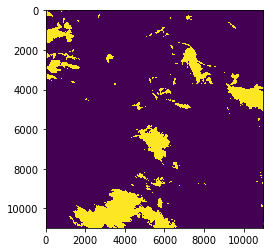

In [22]:
print('Opaque cloud mask-')
plt.imshow(get_cloudmask_image(cloudmasks_raw, cloud_types=['OPAQUE']))
plt.show()

Cirrus cloud mask-


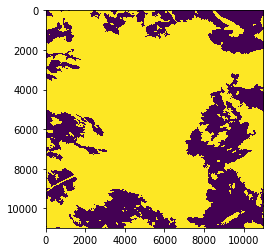

In [23]:
print('Cirrus cloud mask-')
plt.imshow(get_cloudmask_image(cloudmasks_raw, cloud_types=['CIRRUS']))
plt.show()

Now we shall begin the cloud cleaning process -

In [3]:
# These methods merge different channels and create a colored image

def create_bgr_img(b, g, r):
    im = np.vstack([[b], [g], [r]])
    im = np.rollaxis(im, 0, 3)
    if rgb:
        im[:, :, [0, 2]] = im[:, :, [2, 0]]
    return im

def reconstruct_org_tcl_img(b_path, g_path, r_path, rgb=True):
    b = glm.Jp2k(b_path)[:]
    g = glm.Jp2k(g_path)[:]
    r = glm.Jp2k(r_path)[:]
    im, _, _, _ = reconstruct_color_img(b, g, r, rgb=rgb)
    return im, b, g, r

def reconstruct_color_img(b, g, r, rgb=True):
    clahe = cv2.createCLAHE()
    b_pp = clahe.apply(b)
    g_pp = clahe.apply(g)
    r_pp = clahe.apply(r)
    im = create_bgr_img(b_pp, g_pp, r_pp, rgb=rgb)
    return im, b_pp, g_pp, r_pp

First we reconstruct the original true color image using spectral band indices 2, 3 & 4 as mentioned in the documentation at https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/definitions

In [25]:
reconstructed_tcl_img, b_true, g_true, r_true = reconstruct_org_tcl_img(spectral_img_paths_sorted[1],
                                                                        spectral_img_paths_sorted[2],
                                                                        spectral_img_paths_sorted[3],
                                                                        rgb=True)
reconstructed_tcl_img_8bit = ((reconstructed_tcl_img / 65535) * 255).astype(np.uint8)
true_imgs = np.array([b_true, g_true, r_true])
recons_path = out_dir + os.sep + 'true_color_reconstructed_bands234.tiff'
tiff.imsave(open(recons_path, 'wb'), reconstructed_tcl_img)

Original image scaled to 8 bit color -


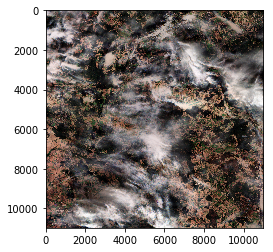

In [76]:
print('Original image scaled to 8 bit color -')
plt.imshow(reconstructed_tcl_img_8bit)
plt.show()

Opaque & Cirrus merged cloud masks (showing again for clarity)


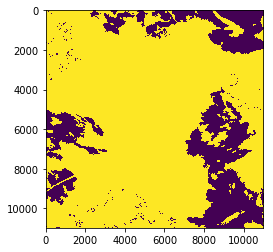

In [77]:
print('Opaque & Cirrus merged cloud masks (showing again for clarity)')
plt.imshow(cloudmask_reconstructed)
plt.show()

In [26]:
cloudmask = cloudmask_reconstructed.astype(np.uint16)
cloudmask[cloudmask > 0] = 1

extraction_masks_raw = spectral_imgs[cloud_removal_bgr_extraction_channel_indices]
extraction_masks = []

Different spectral maps have different resolutions; so we perform Lanczos Interpolation to bring them all to the same resolution as the original true color image.

In [27]:
for em in extraction_masks_raw:
    im = cv2.resize(em[:], (tcl_width, tcl_height), interpolation=cv2.INTER_LANCZOS4)
    extraction_masks.append(im)

In [28]:
extraction_masks[0] = extraction_masks[1] # DOING AWAY WITH BLUE CHANNEL AS IT IS TOO CLOUDY

In [29]:
b_ext, g_ext, r_ext = extraction_masks
ext_reconstructed, _, _, _ = reconstruct_color_img(b_ext, g_ext, r_ext, rgb=True)

ext_bands = np.array(cloud_removal_bgr_extraction_channel_indices) + 1
ext_recons_path = out_dir + os.sep + 'true_color_reconstructed_bands_' +\
                  '-'.join(list(map(str, ext_bands))) + '.tiff'
tiff.imsave(open(ext_recons_path, 'wb'), ext_reconstructed)

Visualizing the false color image from the masks we shall use for deblurring the  clouds-

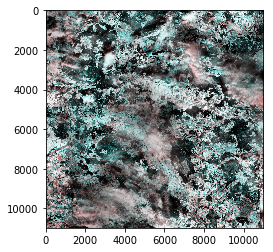

In [30]:
plt.imshow(u16_to_u8(ext_reconstructed))
plt.show()

In [31]:
extraction_masks = np.array(extraction_masks)
cloudmask_repeated = np.tile(cloudmask, [3, 1, 1])

# Picking out only cloud masked regions from the extraction maps
# (those spectral maps chosen for cloud cleaning)
cloud_cleaned_img_raw = (true_imgs * (1 - cloudmask_repeated)) + (extraction_masks * cloudmask_repeated)
cloud_cleaned_img_raw = cloud_cleaned_img_raw.astype(np.uint16)

In [34]:
cloud_cleaned_img, _, _, _ = reconstruct_color_img(cloud_cleaned_img_raw[0],
                                                   cloud_cleaned_img_raw[1],
                                                   cloud_cleaned_img_raw[2],
                                                   rgb=True)

Final cloud cleaned image -


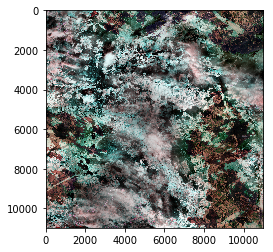

In [35]:
# cloud_cleaned_img_8bit = ((cloud_cleaned_img / 65535) * 255).astype(np.uint8)
print('Final cloud cleaned image -')
plt.imshow(u16_to_u8(cloud_cleaned_img))
plt.show()

For comparison, the original image is as follows-


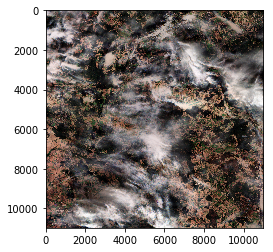

In [36]:
print('For comparison, the original image is as follows-')
plt.imshow(reconstructed_tcl_img_8bit)
plt.show()

The most significant part of the cleaning in this image is presented below-

Original Image


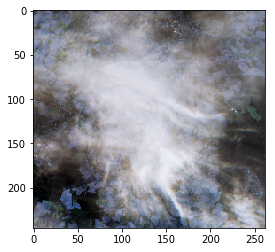

In [39]:
print('Original Image')
plt.imshow(cv2.imread('s2a_201609_t33uut_org_highlight.png'))
plt.show()

Cloud cleaned


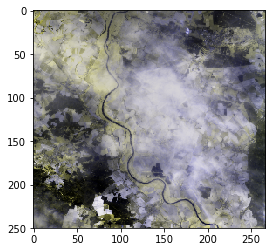

In [40]:
print('Cloud cleaned')
plt.imshow(cv2.imread('s2a_201609_t33uut_cloudcleaned_highlight.png'))
plt.show()

Packing all of this in to a neat function, we have -

In [18]:
# bl_xy, tr_xy - parameters related to the global tile co-ordinates being processed

def msi_l1c_image_process(folder_path, bl_xy = [300004, 5690215], tr_xy = [409805, 5800015]):
    print('Processing', folder_path)
    root_dir_path_prefix = folder_path + os.sep + 'GRANULE'
    root_dir_path = glob(root_dir_path_prefix + os.sep + '*')[0]

    img_dir_path = root_dir_path + os.sep + 'IMG_DATA'
    gml_dir_path = root_dir_path + os.sep + 'QI_DATA'

    out_dir = folder_path.split(os.sep)[-1]
    force_makedir(out_dir)

    spectral_img_paths = glob(img_dir_path + os.sep + '*_B*.jp2')
    if len(spectral_img_paths) == 0:
        tmp = img_dir_path + os.sep + 'R60m'
        suffix = '_' + tmp.split(os.sep)[-1][1:]
        spectral_img_paths = np.array(glob(tmp + os.sep + '*_B*.jp2'))
        spectral_indices = np.array([int(p.replace(suffix, '').replace('8A', '08')
                                         .split('_')[-1][1:].replace('.jp2', ''))
                                     for p in spectral_img_paths])
        spectral_indices[spectral_indices > 9] = spectral_indices[spectral_indices > 9] - 1
        cloud_removal_bgr_extraction_channel_indices = [5, 9, 10]
    else:
        spectral_img_paths = np.array([p for p in spectral_img_paths if '_B8A' not in p])
        spectral_indices = np.array([int(p.split('_')[-1][1:].replace('.jp2', '')) for p in spectral_img_paths])
        cloud_removal_bgr_extraction_channel_indices = [5, 10, 11]

    spectral_indices = spectral_indices - 1
    spectral_indices_argsorted = np.argsort(spectral_indices)
    spectral_img_paths_sorted = spectral_img_paths[spectral_indices_argsorted]

    spectral_imgs = np.array(list(map(glm.Jp2k, spectral_img_paths_sorted)))
    tcl_height, tcl_width = spectral_imgs[1].shape

    # ---------------------True Color Image reconstruction from spectral images--------------------- #

    print('Reconstructing true color image...')
    reconstructed_tcl_img, b_true, g_true, r_true = reconstruct_org_tcl_img(spectral_img_paths_sorted[1],
                                                                            spectral_img_paths_sorted[2],
                                                                            spectral_img_paths_sorted[3],
                                                                            rgb=True)
    reconstructed_tcl_img_8bit = ((reconstructed_tcl_img / 65535) * 255).astype(np.uint8)
    true_imgs = np.array([b_true, g_true, r_true])
    recons_path = out_dir + os.sep + 'true_color_reconstructed_bands234.tiff'
    tiff.imsave(open(recons_path, 'wb'), reconstructed_tcl_img)

    # ---------------------True Color Image reconstruction from spectral images--------------------- #

    # ---------------------Cloud coverage polygon reading--------------------- #

    print('Parsing cloud coverage files and generating masks')
    cloudmask_filepath = gml_dir_path + os.sep + 'MSK_CLOUDS_B00.gml'
    with open(cloudmask_filepath, 'rb') as f:
        cloudmasks_raw = f.readlines()
    cloudmasks_normalized_xy = extract_cloudmasks(cloudmasks_raw, bl_xy=bl_xy, tr_xy=tr_xy)

    scale_fn = lambda cmsk_norm: (cmsk_norm * [tcl_width, tcl_height]).astype(np.int32)
    cloudmasks_scaled = list(map(scale_fn, cloudmasks_normalized_xy))

    cloudmask_reconstructed = np.zeros([tcl_height, tcl_width], dtype=np.uint8)
    for i in range(len(cloudmasks_scaled)):
        cv2.drawContours(cloudmask_reconstructed, cloudmasks_scaled, i, 255, -1)
    cloudmask_img_path = out_dir + os.sep + 'gml_cloudmasks_reconstructed.png'
    cv2.imwrite(cloudmask_img_path, cloudmask_reconstructed)

    # ---------------------Cloud coverage polygon reading--------------------- #

    # ---------------------Cloud Removal--------------------- #

    print('Cleaning clouds')
    cloudmask = cloudmask_reconstructed.astype(np.uint16)
    cloudmask[cloudmask > 0] = 1

    extraction_masks_raw = spectral_imgs[cloud_removal_bgr_extraction_channel_indices]
    extraction_masks = []
    for em in extraction_masks_raw:
        im = cv2.resize(em[:], (tcl_width, tcl_height), interpolation=cv2.INTER_LANCZOS4)
        extraction_masks.append(im)

    extraction_masks[0] = extraction_masks[1] # DOING AWAY WITH BLUE CHANNEL AS IT IS TOO CLOUDY
    b_ext, g_ext, r_ext = extraction_masks
    ext_reconstructed, _, _, _ = reconstruct_color_img(b_ext, g_ext, r_ext, rgb=True)

    ext_bands = np.array(cloud_removal_bgr_extraction_channel_indices) + 1
    ext_recons_path = out_dir + os.sep + 'true_color_reconstructed_bands_' +\
                      '-'.join(list(map(str, ext_bands))) + '.tiff'
    tiff.imsave(open(ext_recons_path, 'wb'), ext_reconstructed)

    extraction_masks = np.array(extraction_masks)
    cloudmask_repeated = np.tile(cloudmask, [3, 1, 1])
    # extraction_masks_multipliers = (extraction_masks * cloudmask_repeated) / 65535
    # extraction_masks_multipliers[cloudmask_repeated == 0] = 1.

    cloud_cleaned_img_raw = (true_imgs * (1 - cloudmask_repeated)) + (extraction_masks * cloudmask_repeated)
    cloud_cleaned_img_raw = cloud_cleaned_img_raw.astype(np.uint16)

    cloud_cleaned_img, _, _, _ = reconstruct_color_img(cloud_cleaned_img_raw[0],
                                                       cloud_cleaned_img_raw[1],
                                                       cloud_cleaned_img_raw[2],
                                                       rgb=True)
    cloud_cleaned_img_8bit = ((cloud_cleaned_img / 65535) * 255).astype(np.uint8)
    cloudcleaned_img_path = out_dir + os.sep + 'cloud_cleaned.tiff'
    tiff.imsave(open(cloudcleaned_img_path, 'wb'), cloud_cleaned_img)

    return cloud_cleaned_img, cloudmask_reconstructed, cloud_cleaned_img_8bit, reconstructed_tcl_img_8bit

In [19]:
# north (includes Berlin)
s2a_201609_l1c_t33uuu_folder = [f for f in sentinel_2_MSI_folders if '201609' in f and 'T33UUU' in f][0]

cloud_cleaned_img_16bit_s2a_201609_l1c_t33uuu, cloudmask_reconstructed_8bit_s2a_201609_l1c_t33uuu, \
cloud_cleaned_img_8bit_s2a_201609_l1c_t33uuu, reconstructed_tcl_img_8bit_s2a_201609_l1c_t33uuu \
    = msi_l1c_image_process(s2a_201609_l1c_t33uuu_folder, bl_xy = [300004, 5790234], tr_xy = [409805, 5900015])

Processing data\S2A_MSIL1C_20160929T102022_N0204_R065_T33UUU_20160929T102344.SAFE
Reconstructing true color image...
Parsing cloud coverage files and generating masks
Cleaning clouds


Original Image-


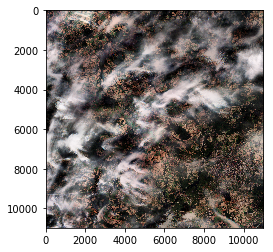

In [20]:
print('Original Image-')
plt.imshow(reconstructed_tcl_img_8bit_s2a_201609_l1c_t33uuu)
plt.show()

Cloud coverage-


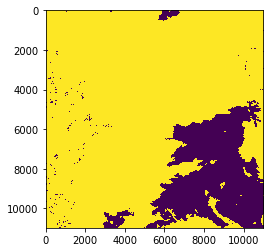

In [21]:
print('Cloud coverage-')
plt.imshow(cloudmask_reconstructed_8bit_s2a_201609_l1c_t33uuu)
plt.show()

Cloud cleaned image-


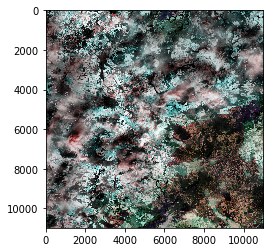

In [22]:
print('Cloud cleaned image-')
plt.imshow(cloud_cleaned_img_8bit_s2a_201609_l1c_t33uuu)
plt.show()

In [23]:
# south (covers same area as 201609 T3UUT)
s2a_201809_l2a_t33uut_folder = [f for f in sentinel_2_MSI_folders if '201809' in f and 'T33UUT' in f][0]

cloud_cleaned_img_16bit_s2a_201809_l2a_t33uut, cloudmask_reconstructed_8bit_s2a_201809_l2a_t33uut, \
cloud_cleaned_img_8bit_s2a_201809_l2a_t33uut, reconstructed_tcl_img_8bit_s2a_201809_l2a_t33uut \
    = msi_l1c_image_process(s2a_201809_l2a_t33uut_folder, bl_xy = [300004, 5690215], tr_xy = [409805, 5800015])

Processing data\S2A_MSIL2A_20180906T101021_N0208_R022_T33UUT_20180906T131549.SAFE
Reconstructing true color image...
Parsing cloud coverage files and generating masks
Cleaning clouds


Original Image-


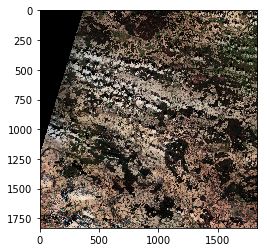

In [24]:
print('Original Image-')
plt.imshow(reconstructed_tcl_img_8bit_s2a_201809_l2a_t33uut)
plt.show()

Cloud coverage-


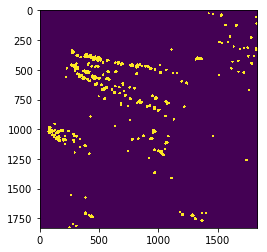

In [25]:
print('Cloud coverage-')
plt.imshow(cloudmask_reconstructed_8bit_s2a_201809_l2a_t33uut)
plt.show()

Cloud cleaned image-


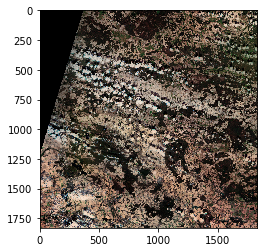

In [26]:
print('Cloud cleaned image-')
plt.imshow(cloud_cleaned_img_8bit_s2a_201809_l2a_t33uut)
plt.show()

As can be seen this method is effective over areas with large and dense cloud coverage. As has been processed in this case for clouds, similar methodology can be applied for other map features like soil, forest, etc.